In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [4]:
os.environ['CUDA_DEVICE_ORDER'] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "4"

In [5]:
# %%
from fastai.text import *
from datahelper.Data import *
from fastai.text.transform import *

In [6]:
torch.cuda.device_count()

1

In [7]:
hyper_params = {
    "max_sequence_length": 20*70,
    "batch_size": 64,
    "num_epochs1": 12,
    "num_epochs2": 15,
    "num_aspect": 5,
    "num_rating": 5,
}

# Load LM Databunch and LM Learner

In [8]:
!pwd

/disk2/yifan/code/SAAM/src/SAAM_V3_Hotel


In [8]:
# cls_db = load_data("./data/hotel_balance_LengthFix1_3000per", "hotel_clas_databunch_2020.TraValTes")
cls_db = load_data("../../data/", "beer_clas_databunch_rint.TraVal")
cls_db.batch_size=hyper_params["batch_size"]
cls_db.batch_size

/home/yifan/anaconda3/envs/saam/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


64

In [9]:
len( cls_db.vocab.itos )

31600

# Tools

### Sentence Feature Combo Pooling (1200)

In [10]:
def average_emb(output, start, end):
    avg_pool = output[start:end, :].mean(dim=0)
    return avg_pool

def sentence_avgpool(output, mask, p_index):
#     output = outputs[-1]
    doc_start = mask.int().sum(dim=1)
    
    batch = []
    for doci in range(0,output.shape[0]):
        pi = p_index[doci,:].nonzero(as_tuple=True)[0].int()
        doc = []
        for senti in range( len(pi) ):
            if senti==0:
                # from start of doc to end of first sent
                doc.append( average_emb(output[doci,:,:], doc_start[doci], pi[senti]) )
            else:
                # from previous period to next
                doc.append( average_emb(output[doci,:,:], pi[senti-1]+1, pi[senti]) )
            
        batch.append( torch.stack(doc, 0) )

    return batch

def sentence_finalpool(output, mask, p_index):
#     output = outputs[-1]
    
    batch = []
    for doci in range(0,output.shape[0]):
        doc = output[doci,p_index[doci,:],:]
        batch.append( doc )

    return batch

## DEFINE MODEL

In [11]:
class SentenceEncoder(Module):
    "Create an encoder over `module` that can process a full sentence."
    def __init__(self, bptt:int, max_len:int, module:nn.Module, vocab, pad_idx:int=1):
        print("Encoder init")
        self.max_len,self.bptt,self.module,self.pad_idx = max_len,bptt,module,pad_idx
        self.vocab = vocab
        self.period_index = self.vocab.stoi["xxperiod"]

    def concat(self, arrs:Collection[Tensor])->Tensor:
        "Concatenate the `arrs` along the batch dimension."
        return [torch.cat([l[si] for l in arrs], dim=1) for si in range_of(arrs[0])]

    def reset(self):
        if hasattr(self.module, 'reset'): self.module.reset()

    def forward(self, input:LongTensor)->Tuple[Tensor,Tensor]:
        bs,sl = input.size()
        self.reset()
        raw_outputs,outputs,masks = [],[],[]
        p_index = []
        for i in range(0, sl, self.bptt):
            r, o = self.module(input[:,i: min(i+self.bptt, sl)])
            if i>(sl-self.max_len):
                masks.append(input[:,i: min(i+self.bptt, sl)] == self.pad_idx)
                raw_outputs.append(r)
                outputs.append(o)
                p_index.append( input[:,i: min(i+self.bptt, sl)] == self.period_index )

                
        # print("number of sentences in docs:")
#         n_sent = torch.sum( x==self.vocab.stoi["xxperiod"] , dim=1)
        # print(n_sent)
        
        # print("locating period marks")
        period_index = torch.cat(p_index,dim=1)
        
        return self.concat(raw_outputs),self.concat(outputs), \
               torch.cat(masks,dim=1),period_index

# CLS 02

In [12]:
# experiment.add_tag("CLAS02")
# experiment.add_tag("2020AVG")

# ATTENTIONAL AVERAGING, COMPLETELY INDEPENDENT SENTI OUT

class Cls02ATT400(Module):
    "Create a linear classifier with pooling."
    def __init__(self, n_asp:int, n_rat:int, layers:Collection[int], drops:Collection[float]):
        print("CLS init")
        print("Num Aspect: "+str(n_asp) )
        print("Num Rating: "+str(n_rat) )
        self.n_asp = n_asp
        self.n_rat = n_rat
        
        self.proj_dim = 128
        
        self.aspect_projector = nn.Sequential(* ( bn_drop_lin( 400, self.proj_dim, p=0.5, actn=nn.GELU() ) ) )
        self.senti_projector = nn.Sequential(* ( bn_drop_lin( 400, self.proj_dim, p=0.5, actn=nn.GELU() ) ) )
        
        self.hid_size = 64
        # aspect projector, with additional 1 aspect for throw out
        mod_layers = []
#         mod_layers += bn_drop_lin( self.proj_dim, self.hid_size, p=0.35, actn=nn.GELU() )
#         mod_layers += bn_drop_lin( self.hid_size, self.n_asp + 1, p=0.2, actn=torch.nn.Softmax(dim=1) )
        mod_layers += bn_drop_lin( self.proj_dim, self.n_asp + 1, p=0.35, actn=torch.nn.Softmax(dim=1) )
        self.aspect = nn.Sequential(*mod_layers)
        
#         self.s0 = nn.Sequential(* ( bn_drop_lin( self.proj_dim, self.n_rat, p=0.35, actn=None ) ) )  # from 256 to 5
#         self.s1 = nn.Sequential(* ( bn_drop_lin( self.proj_dim, self.n_rat, p=0.35, actn=None ) ) )
#         self.s2 = nn.Sequential(* ( bn_drop_lin( self.proj_dim, self.n_rat, p=0.35, actn=None ) ) )
#         self.s3 = nn.Sequential(* ( bn_drop_lin( self.proj_dim, self.n_rat, p=0.35, actn=None ) ) )
#         self.s4 = nn.Sequential(* ( bn_drop_lin( self.proj_dim, self.n_rat, p=0.35, actn=None ) ) )
#         self.s5 = nn.Sequential(* ( bn_drop_lin( self.proj_dim, self.n_rat, p=0.35, actn=None ) ) )

        self.sentiments = nn.Sequential(* ( bn_drop_lin( self.proj_dim, self.n_rat, p=0.35, actn=None ) ) )
#         self.sentiments.append( self.s0 )
#         self.sentiments.append( self.s1 )
#         self.sentiments.append( self.s2 )
#         self.sentiments.append( self.s3 )
#         self.sentiments.append( self.s4 )
#         self.sentiments.append( self.s5 )


    def forward(self, input:Tuple[Tensor,Tensor,Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask,p_index = input
        batch_size = outputs[-1].shape[0]
        
        sentence_emb = outputs[-1].view(-1, 400)
        
        aspect_projection = self.aspect_projector( sentence_emb )  # [n_token, 256]
        senti_projection = self.senti_projector( sentence_emb )  # [n_token, 256]
        
        aspect_projection = aspect_projection.view(batch_size, -1, self.proj_dim)  # [batch, doc_len, 256]
        senti_projection = senti_projection.view(batch_size, -1, self.proj_dim)
        
        aspect_batch = sentence_avgpool(aspect_projection, mask, p_index)
        senti_batch = sentence_avgpool(senti_projection, mask, p_index)
        
        allsent_aspect_proj = torch.cat(aspect_batch, dim=0)        # [n_sentence, 256]
        allsent_senti_proj = torch.cat(senti_batch, dim=0)          # [n_sentence, 256]
        
        aspect_dist = self.aspect(allsent_aspect_proj)         # [n_sentence, aspect6]

        sent_bmm = torch.bmm(aspect_dist[:,0:self.n_asp].unsqueeze(2), allsent_senti_proj.unsqueeze(1))  # [319, 6, 256]
        
        all_doc_emb = []
        aspect_doc = []
        sentim_doc = []
        cur = 0
        for doci in range(0, len(aspect_batch)):
            sn = aspect_batch[doci].shape[0]
            doc_emb_avg = torch.sum(sent_bmm[cur:(cur+sn), :, : ], dim=0, keepdim=True) # [1, 6, 400]
            asp_w_sum = torch.sum(aspect_dist[cur:(cur+sn),0:self.n_asp], dim=0, keepdim=True)     # [1, 6]
            doc_emb_avg = doc_emb_avg / asp_w_sum[:,:,None]                             # [1, 6, 400]
            all_doc_emb.append( doc_emb_avg )
            aspect_doc.append( aspect_dist[cur:(cur+sn), :] )
            
            cur = cur + sn

        all_doc_emb = torch.cat( all_doc_emb, dim=0 )          # [batch, asp, 400]
        
        result_senti = [ self.sentiments( all_doc_emb[:,aspi,:] ) for aspi in range(0,self.n_asp)] # [batch, ra]
        
        result = torch.stack(result_senti, dim=1)  # [batch, asp, sentiment5]
        
        return result,raw_outputs,outputs,aspect_doc

# Building Learner

In [13]:
def get_text_classifier(arch:Callable, vocab_sz:int, vocab, n_class:int, bptt:int=70, max_len:int=20*70, config:dict=None,
                        drop_mult:float=1., lin_ftrs:Collection[int]=None, ps:Collection[float]=None,
                        pad_idx:int=1) -> nn.Module:
    "Create a text classifier from `arch` and its `config`, maybe `pretrained`."
    print("CUSTOM DEFINED CLASSIFIER")
    meta = text.learner._model_meta[arch]
    config = ifnone(config, meta['config_clas']).copy()
    for k in config.keys():
        if k.endswith('_p'): config[k] *= drop_mult
    if lin_ftrs is None: lin_ftrs = [50]
    if ps is None:  ps = [0.1]*len(lin_ftrs)
    layers = [config[meta['hid_name']] * 3] + lin_ftrs + [n_class]
    ps = [config.pop('output_p')] + ps
    init = config.pop('init') if 'init' in config else None
    encoder = SentenceEncoder(bptt, max_len, arch(vocab_sz, **config), vocab, pad_idx=pad_idx)
    cls_layer = Cls02ATT400(n_asp=hyper_params["num_aspect"], n_rat=hyper_params["num_rating"], layers=layers, drops=ps)
    model = SequentialRNN(encoder, cls_layer)
    return model if init is None else model.apply(init)

In [14]:
def text_classifier_learner(data:DataBunch, arch:Callable, bptt:int=70, max_len:int=20*70, config:dict=None,
                            pretrained:bool=True, drop_mult:float=1., lin_ftrs:Collection[int]=None,
                            ps:Collection[float]=None, **learn_kwargs) -> 'TextClassifierLearner':
    "Create a `Learner` with a text classifier from `data` and `arch`."
    model = get_text_classifier(arch, len(data.vocab.itos), data.vocab, data.c, bptt=bptt, max_len=max_len,
                                config=config, drop_mult=drop_mult, lin_ftrs=lin_ftrs, ps=ps)
    meta = text.learner._model_meta[arch]
    learn = RNNLearner(data, model, split_func=meta['split_clas'], **learn_kwargs)
    if pretrained:
        if 'url' not in meta:
            warn("There are no pretrained weights for that architecture yet!")
            return learn
        model_path = untar_data(meta['url'], data=False)
        fnames = [list(model_path.glob(f'*.{ext}'))[0] for ext in ['pth', 'pkl']]
        learn = learn.load_pretrained(*fnames, strict=False)
        learn.freeze()
    return learn

## Classification loss and metrics

In [15]:
class MultiLabelCEL(nn.CrossEntropyLoss):
    def forward(self, input, target, nasp=5):
        target = target.long()
        loss = 0
        for i in range(nasp):
            loss = loss + super(MultiLabelCEL, self).forward(input[:,i,:], target[:,i])
        
        return loss

In [16]:
def multi_acc(preds, targs, nasp=5, nrat=5):
    preds = preds[:,0:nasp,:]
    preds = preds.contiguous().view(-1, nrat)
    preds = torch.max(preds, dim=1)[1]
    targs = targs.contiguous().view(-1).long()
    return (preds==targs).float().mean()

In [17]:
def acc_0(preds, targs):
    preds = torch.max(preds, dim=2)[1]
    targs = targs.contiguous().long()
    return (preds[:,0]==targs[:,0]).float().mean()
def acc_1(preds, targs):
    preds = torch.max(preds, dim=2)[1]
    targs = targs.contiguous().long()
    return (preds[:,1]==targs[:,1]).float().mean()
def acc_2(preds, targs):
    preds = torch.max(preds, dim=2)[1]
    targs = targs.contiguous().long()
    return (preds[:,2]==targs[:,2]).float().mean()
def acc_3(preds, targs):
    preds = torch.max(preds, dim=2)[1]
    targs = targs.contiguous().long()
    return (preds[:,3]==targs[:,3]).float().mean()
def acc_4(preds, targs):
    preds = torch.max(preds, dim=2)[1]
    targs = targs.contiguous().long()
    return (preds[:,4]==targs[:,4]).float().mean()

## create the objects

In [18]:
mloss = MultiLabelCEL()
cls_learn = text_classifier_learner(cls_db, AWD_LSTM, 
                                    loss_func=mloss,
                                    drop_mult=1.1,
                                    metrics=[multi_acc,acc_0,acc_1,acc_2,acc_3,acc_4],
                                    bptt=70,
                                    max_len=hyper_params["max_sequence_length"],
#                                     clip=1.0
                                   )

CUSTOM DEFINED CLASSIFIER
Encoder init
CLS init
Num Aspect: 5
Num Rating: 5
FREEZING
Sequential(
  (0): Embedding(31600, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(31600, 400, padding_idx=1)
  )
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): Cls02ATT400(
    (aspect_projector): Sequential(
      (0): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=400, out_features=128, bias=True)
      (3): GELU()
    )
    (senti_projector): Sequential(
      (0): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [19]:
_=cls_learn.load_encoder('lm_enc_beer.1115')

FREEZING
Sequential(
  (0): Embedding(31600, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(31600, 400, padding_idx=1)
  )
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): Cls02ATT400(
    (aspect_projector): Sequential(
      (0): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=400, out_features=128, bias=True)
      (3): GELU()
    )
    (senti_projector): Sequential(
      (0): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=400, 

# Train log

## CLAS 02

In [20]:
# 2020 AVG + TOKEN PROJECTOR
cls_learn.fit_one_cycle( 6 , max_lr=slice(2e-3,2e-2), wd=0.01)

epoch,train_loss,valid_loss,multi_acc,acc_0,acc_1,acc_2,acc_3,acc_4,time
0,4.898546,4.593500,0.564130,0.571813,0.556663,0.584432,0.566227,0.541513,11:08
1,4.902886,4.802731,0.536738,0.524313,0.543763,0.529095,0.551680,0.534842,11:35
2,4.840013,4.460827,0.591818,0.579047,0.581779,0.628757,0.583347,0.586160,11:16
3,4.800778,4.393319,0.596520,0.581699,0.578605,0.634826,0.587365,0.600105,10:21
4,4.700907,4.350946,0.601157,0.590138,0.589736,0.637076,0.591344,0.597492,09:55
5,4.714949,4.529812,0.592140,0.582061,0.590620,0.620800,0.578122,0.589093,10:05


/home/yifan/anaconda3/envs/saam/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/yifan/anaconda3/envs/saam/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obj

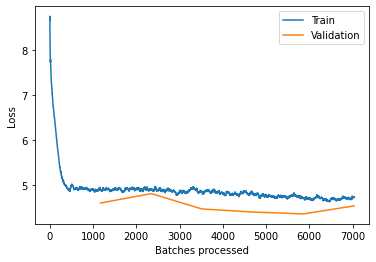

In [21]:
fig = cls_learn.recorder.plot_losses()

In [22]:
cls_learn.save('hotel.clas.saamv2.learner')

In [22]:
cls_learn.load('hotel.clas.saamv2.learner')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (75113 items)
x: TextList
xxbos a lot of foam xxperiod xxmaj but a lot xxperiod xxmaj in the smell some banana , and then lactic and tart xxperiod xxmaj not a good start xxperiod xxmaj quite dark orange in color , with a lively carbonation ( now visible , under the foam ) xxperiod xxmaj again tending to lactic sourness xxperiod xxmaj same for the taste xxperiod xxmaj with some yeast and banana xxperiod,xxbos xxmaj dark red color , light beige foam , average xxperiod xxmaj in the smell malt and caramel , not really light xxperiod xxmaj again malt and caramel in the taste , not bad in the end xxperiod xxmaj maybe a note of honey in teh back , and a light fruitiness xxperiod xxmaj average body xxperiod xxmaj in the aftertaste a light bitterness , with the malt and red fruit xxperiod xxmaj nothing exceptional , but not bad , drinkable beer xxperiod,xxbos xxmaj almost totally black xxperiod xxmaj beige foam , quite compact , not bad xxper

In [23]:
cls_learn.unfreeze()

UN-FREEZING
Sequential(
  (0): Embedding(31600, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(31600, 400, padding_idx=1)
  )
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): Cls02ATT400(
    (aspect_projector): Sequential(
      (0): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=400, out_features=128, bias=True)
      (3): GELU()
    )
    (senti_projector): Sequential(
      (0): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_fe

In [24]:
# 2020 AVG + TokenProj
cls_learn.fit_one_cycle(10, wd=0.01)

epoch,train_loss,valid_loss,multi_acc,acc_0,acc_1,acc_2,acc_3,acc_4,time
0,4.668399,4.313121,0.601632,0.589535,0.587767,0.635187,0.597452,0.598216,12:29
1,4.574408,4.301300,0.604107,0.593032,0.595242,0.627793,0.599904,0.604565,11:55
2,4.507301,4.271932,0.605883,0.599582,0.597090,0.644430,0.587245,0.601069,11:59
3,4.485294,4.329984,0.602668,0.598376,0.592349,0.639809,0.581418,0.601390,12:18
4,4.393159,4.194492,0.615214,0.608986,0.597131,0.649293,0.602194,0.618470,12:35
5,4.395024,4.136134,0.620479,0.609026,0.606092,0.651503,0.613045,0.622729,12:22
6,4.373187,4.133709,0.621219,0.609749,0.602998,0.653512,0.615657,0.624176,12:16
7,4.352146,4.144817,0.619249,0.612361,0.598497,0.659219,0.606936,0.619233,12:44
8,4.380236,4.159314,0.619418,0.611718,0.601471,0.655883,0.608182,0.619836,12:13
9,4.333897,4.116521,0.621934,0.612562,0.600948,0.658174,0.613286,0.624699,12:15


/home/yifan/anaconda3/envs/saam/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/yifan/anaconda3/envs/saam/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obj

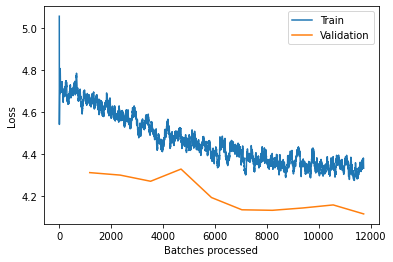

In [25]:
# 2020 AVG
fig = cls_learn.recorder.plot_losses()

In [26]:
cls_learn.save('hotel.clas.saamv2.2.learner')

# Load Test Data

In [26]:
sent_num_file = ["aspect_0.count", "test_aspect_0.count"]
rating_file = ["aspect_0.rating", "test_aspect_0.rating"]
content_file = ["aspect_0.txt", "test_aspect_0.txt"]

dataset_dir = "./data/hotel_balance_LengthFix1_3000per/"

In [27]:
def concat_to_doc(sent_list, sent_count):
    start_index = 0
    docs = []
    for s in sent_count:
#         doc = " xxPERIOD ".join(sent_list[start_index:start_index + s])
#         doc = doc + " xxPERIOD "
        docs.append(sent_list[start_index:start_index + s])
        start_index = start_index + s
    return docs

In [28]:
TRAIN_DATA = 0
TEST_DATA = 1

In [29]:
# Load Count
sent_count_test = list(open(dataset_dir + sent_num_file[TEST_DATA], "r").readlines())
sent_count_test = [int(s) for s in sent_count_test if (len(s) > 0 and s != "\n")]
print( sent_count_test[0:5] )

# Load Ratings
aspect_rating_test = list(open(dataset_dir + rating_file[TEST_DATA], "r").readlines())
aspect_rating_test = [s for s in aspect_rating_test if (len(s) > 0 and s != "\n")]

aspect_rating_test = [s.split(" ") for s in aspect_rating_test]
aspect_rating_test = np.array(aspect_rating_test)[:, 0:-1]
aspect_rating_test = aspect_rating_test.astype(np.int) - 1
aspect_rating_test = pd.DataFrame(aspect_rating_test)
print( aspect_rating_test.head() )

# Load Sents
sents_test = list(open(dataset_dir + content_file[TEST_DATA], "r").readlines())
sents_test = [s.strip() for s in sents_test]

# Sents to Doc
docs_test = concat_to_doc(sents_test, sent_count_test)

docs_test = pd.DataFrame({doc:docs_test})

[9, 30, 25, 33, 29]
   0  1  2  3  4  5
0  1  0  0  3  1  1
1  2  2  1  2  3  3
2  4  4  4  3  4  4
3  3  2  3  3  3  4
4  3  4  3  4  4  4


In [30]:
df_test = pd.concat( [aspect_rating_test, docs_test], axis=1, ignore_index=True )
df_test.head()

,0,1,2,3,4,5,6
0,1,0,0,3,1,1,[definitely not a 5 star resort i 'm dumbfound...
1,2,2,1,2,3,3,"[facilities need work, we visited excellence f..."
2,4,4,4,3,4,4,"[excellence was exactly that, my family and i ..."
3,3,2,3,3,3,4,"[great service , nice hotel , mediocre food, m..."
4,3,4,3,4,4,4,[very relaxing experience just returned from m...


# Test output

In [31]:
def get_clas_acc(asp_index):
    def asp_acc(preds, targs):
        preds = torch.max(preds, dim=2)[1]
        targs = targs.contiguous().long()
        return (preds[:,asp_index]==targs[:,asp_index]).float().mean()
    return asp_acc
def get_clas_mse(asp_index):
    def asp_mse(preds, targs):
        preds = torch.max(preds, dim=2)[1].float()[:,asp_index]
        targs = targs.contiguous().float()[:,asp_index]
        return torch.nn.functional.mse_loss(preds, targs)
    return asp_mse

In [32]:
def get_preds(self,
              ds_type:DatasetType,
              activ:nn.Module=None,
              with_loss:bool=False,
              n_batch:Optional[int]=None,
              pbar:Optional[PBar]=None,
              ordered:bool=False) -> List[Tensor]:
    "Return predictions and targets on the valid, train, or test set, depending on `ds_type`."
    self.model.reset()
    if ordered: np.random.seed(42)
    
    with torch.no_grad():
        outs = []
        asps = []
        for xb,yb in progress_bar(cls_learn.dl(ds_type)):
            out,raw_enc,enc,asp = cls_learn.model(xb)
            outs.append(out)
            for doc in asp:
                asps.append( to_float(doc.cpu()))

    outs = to_float(torch.cat(outs).cpu())
    
    if ordered and hasattr(self.dl(ds_type), 'sampler'):
        np.random.seed(42)
        sampler = [i for i in self.dl(ds_type).sampler]
        reverse_sampler = np.argsort(sampler)
        
        outs = outs[reverse_sampler]
        asps = [asps[i] for i in reverse_sampler]
    return (outs,asps)

In [33]:
outs,asps = get_preds(self=cls_learn, ds_type=DatasetType.Valid, ordered=True)

In [34]:
target = torch.tensor( aspect_rating_test.values )
target

tensor([[1, 0, 0, 3, 1, 1],
        [2, 2, 1, 2, 3, 3],
        [4, 4, 4, 3, 4, 4],
        ...,
        [0, 0, 0, 3, 0, 2],
        [0, 0, 0, 2, 0, 0],
        [0, 0, 0, 1, 0, 1]])

In [35]:
pd.DataFrame.from_dict( {"ASP"+str(ai):[get_clas_acc(ai)(outs, target).item()] for ai in range(6)} )

,ASP0,ASP1,ASP2,ASP3,ASP4,ASP5
0,0.677721,0.60444,0.555764,0.485691,0.549077,0.57395


In [36]:
pd.DataFrame.from_dict( {"ASP"+str(ai):[get_clas_mse(ai)(outs, target).item()] for ai in range(6)} )

,ASP0,ASP1,ASP2,ASP3,ASP4,ASP5
0,0.401444,0.576625,0.675582,0.999465,0.750201,0.878042


# Visualize classification output

In [37]:
asp_inc_overall = True
if not asp_inc_overall: 
    nasp_analysis = hyper_params["num_aspect"] - 1
else:
    nasp_analysis = hyper_params["num_aspect"]
    
np.set_printoptions(precision=3)
asp_name = ["overall", "value", "room", "location", "clean", "service"]
for i in range(10):
    print("truth:")
    print(df_test.iloc[i,0:6].values.flatten().tolist() )
    print("prediction:")
    print( torch.argmax(outs[i][0:6],dim=1) )
    print("doc:")
    dasp = torch.argmax(asps[i][:,0:nasp_analysis],dim=1).numpy()
    if asp_inc_overall: dasp_noall = torch.argmax(asps[i][:,1:6],dim=1).numpy()
#     dasp_dist = torch.nn.functional.softmax(asps[i][:,0:nasp_analysis], dim=1).numpy()
    dasp_dist = asps[i][:,0:nasp_analysis].numpy()
    for senti,s in enumerate(df_test.iloc[i,6]):
        print(s)
        if asp_inc_overall:
            print("          +++ "+ asp_name[dasp[senti]] + " +++ " + asp_name[dasp_noall[senti]+1] + " +++ " + str(dasp_dist[senti]) )
        else:
            print("          +++ "+ asp_name[dasp[senti]+1] + " +++ " + str(dasp_dist[senti]) )
    print("===========")

truth:
[1, 0, 0, 3, 1, 1]
prediction:
tensor([1, 0, 0, 2, 0, 0])
doc:
definitely not a 5 star resort i 'm dumbfounded that this hotel gets good reviews and is so highly rated
          +++ overall +++ value +++ [0.276 0.168 0.095 0.054 0.067 0.142]
it 's decidedly a 3 star property , not 5 stars as indicated
          +++ overall +++ room +++ [0.219 0.146 0.165 0.075 0.078 0.12 ]
the rooms are very dated and run down , old crappy beds and pillows , an old tv and overall poorly maintained
          +++ room +++ room +++ [0.078 0.067 0.608 0.022 0.199 0.025]
the whole property is pretty run down and old - looking
          +++ room +++ room +++ [0.143 0.113 0.34  0.095 0.238 0.056]
the food is subpar , not one meal i had would be called great
          +++ overall +++ service +++ [0.222 0.149 0.052 0.082 0.075 0.178]
the service is uneven and the staff is poorly trained and uninformed
          +++ service +++ service +++ [0.024 0.018 0.002 0.004 0.008 0.943]
many do not comprehend engli

# Visualize regression output

In [35]:
asp_inc_overall = False
if not asp_inc_overall: 
    nasp_analysis = hyper_params["num_aspect"] - 1
else:
    nasp_analysis = hyper_params["num_aspect"]
    
np.set_printoptions(precision=3)
asp_name = ["overall", "value", "room", "location", "clean", "service"]
for i in range(10):
    print("truth:")
    print( df_test.iloc[i,0:6].values.flatten().tolist() )
    print("prediction:")
    print( outs[i][0:6] )
    print("doc:")
    dasp = torch.argmax(asps[i][:,0:nasp_analysis],dim=1).numpy()
    if asp_inc_overall: dasp_noall = torch.argmax(asps[i][:,1:6],dim=1).numpy()
    dasp_dist = torch.nn.functional.softmax(asps[i][:,0:nasp_analysis], dim=1).numpy()
#     dasp_dist = asps[i][:,0:nasp_analysis].numpy()
    for senti,s in enumerate(df_test.iloc[i,6]):
        print(s)
        if asp_inc_overall:
            print("          +++ "+ asp_name[dasp[senti]] + " +++ " + asp_name[dasp_noall[senti]+1] + " +++ " + str(dasp_dist[senti]) )
        else:
            print("          +++ "+ asp_name[dasp[senti]+1] + " +++ " + str( np.around(dasp_dist[senti], decimals=2) ) )
    print("===========")

truth:
[1, 0, 0, 3, 1, 1]
prediction:
tensor([[4.1020e-04, 9.9668e-01, 2.9009e-03, 3.9855e-06, 1.4823e-06],
        [8.2763e-03, 9.6310e-01, 2.8592e-02, 1.9740e-05, 1.5135e-05],
        [9.9990e-01, 1.0335e-04, 4.0020e-08, 2.1092e-08, 5.1732e-09],
        [2.2873e-01, 1.3853e-01, 2.5908e-01, 3.5016e-01, 2.3494e-02],
        [9.5705e-01, 4.2916e-02, 3.6786e-05, 1.6780e-07, 1.2092e-07],
        [9.9998e-01, 1.9123e-05, 1.6604e-09, 5.1853e-12, 3.6041e-11]])
doc:
definitely not a 5 star resort i 'm dumbfounded that this hotel gets good reviews and is so highly rated
          +++ value +++ [0.22 0.2  0.19 0.19 0.19]
it 's decidedly a 3 star property , not 5 stars as indicated
          +++ value +++ [0.22 0.2  0.2  0.19 0.19]
the rooms are very dated and run down , old crappy beds and pillows , an old tv and overall poorly maintained
          +++ location +++ [0.17 0.17 0.28 0.17 0.21]
the whole property is pretty run down and old - looking
          +++ location +++ [0.19 0.18 0.25 0.18 

# eval

In [38]:
def eval_hotel_asp(asp_pred, asp_true, asp_inc_overall):
    asp_to_id = {"value":0, "room":1, "location":2, "cleanliness":3, "service":4, "none":-1}
    asp_true = np.array( [asp_to_id[l] for l in asp_true] )
    print("total true: " + str(len(asp_true)) )
    print("total not none: " + str(sum(asp_true>0)) )
    
    asp_pred_index = []
    if asp_inc_overall:
        for i in range(1000):
            asp_pred_index.append( asp_pred[i][:,1:6].numpy().argsort() )
    else:
        for i in range(1000):
            asp_pred_index.append( asp_pred[i][:,0:5].numpy().argsort() )
    asp_pred_index = np.concatenate( asp_pred_index , axis=0)
    
    result_index = []
    for i,lbl in enumerate(asp_true):
        if(lbl==-1):
            result_index.append(-1)
        else:
            at = np.where(asp_pred_index[i,] == lbl)
            result_index.append(at[0][0])
    result_index = np.array(result_index)
    
    print("Top 1 ACC:")
    print( sum(result_index>=4) / sum(result_index>=0) )
    print("Top 2 ACC:")
    print( sum(result_index>=3) / sum(result_index>=0) )

In [39]:
yifan_label = open(dataset_dir + "test_aspect_0.yifanmarjan.aspect", "r").readlines()
yifan_label = [s.split()[0] for s in yifan_label]

In [40]:
eval_hotel_asp(asps, yifan_label, asp_inc_overall=True)

total true: 1000
total not none: 454
Top 1 ACC:
0.7321772639691715
Top 2 ACC:
0.8863198458574181


In [41]:
fan_label = open(dataset_dir + "test_aspect_0.fan.aspect", "r").readlines()
fan_label = [s.split()[0] for s in fan_label]

In [42]:
eval_hotel_asp(asps, fan_label, asp_inc_overall=True)

total true: 621
total not none: 288
Top 1 ACC:
0.7079646017699115
Top 2 ACC:
0.8849557522123894
